# Dataset analysis
Mouna Ammar & Paul Gazel

In [80]:
from pymongo import MongoClient
from bson.son import SON
import pymongo
import pickle
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [66]:
client = MongoClient(host='localhost', port=27017, maxPoolSize=200)
print(client.list_database_names())

covidDB = client['Covid_db22'].covid_data22

['Covid_db22', 'admin', 'config', 'local']


In [67]:
covidDB.count_documents({})

43229

In this notebook we are going to analyze the main dataset: the articles. To start, we first need to connect to the mongo database where the articles have been inserted. The first think to highlight is that the total number of articles we have in our database is lower than the one we have in the summary recap. This is due to when inserting into the mongo database we check for duplicates. There is a total of 2 897 articles that were duplicates which brings the total articles we have from 46 126 to 43 229. 

Let's start by plotting and example of article as well as the number of articles over time.

In [126]:
covidDB.find_one()

{'_id': ObjectId('61c24e725eec1850518ce434'),
 'source': {'id': 'nbc-news', 'name': 'NBC News'},
 'author': 'Ilene Prusher',
 'title': "The best gifts don't come in shiny boxes",
 'description': 'This holiday season we have an opportunity to extend our time together beyond watching someone’s face as they tear the wrapping off their booty.',
 'publishedAt': '2021-12-12T10:30:18Z',
 'content': 'Supply chains are all gummed up, leaving some shelves as empty as the toilet paper aisles of March 2020. Prices rose by an alarming 6.8 percent last month, the highest annual inflation rate in almost… [+5211 chars]'}

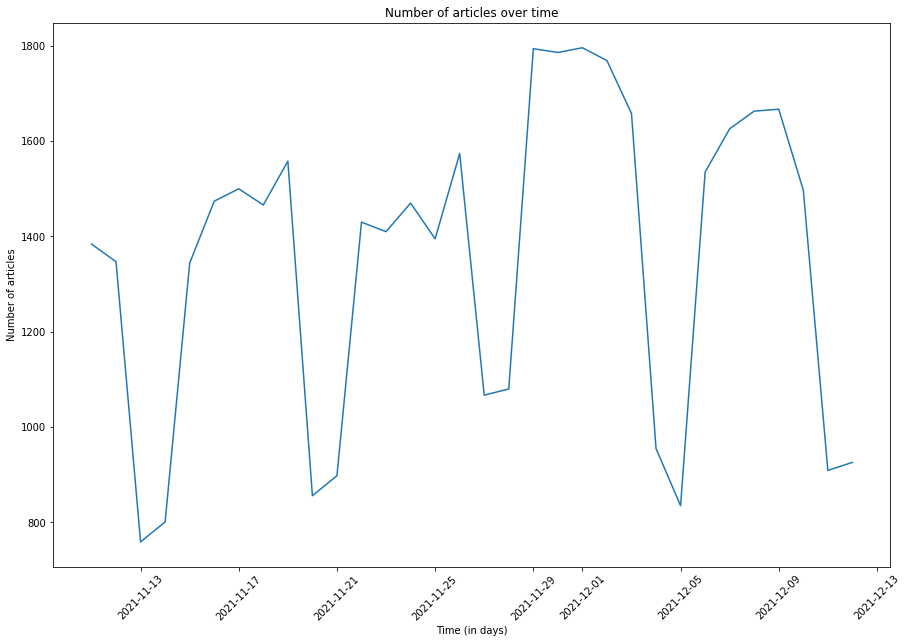

In [72]:
# Start by plotting over time

pipeline = [
    { '$group': {
    '_id': {'$dateToString': { 'date': { '$toDate': '$publishedAt' }, 'format': '%Y-%m-%d' } },
    'count': { '$sum': 1 }
  }},
    {'$sort': SON([('_id', pymongo.ASCENDING)])}
]

res = covidDB.aggregate(pipeline)

x = []
y = []
for sample in res:
    x.append(datetime.strptime(sample['_id'], '%Y-%m-%d'))
    y.append(sample['count'])
    

plt.plot(x, y)
plt.title("Number of articles over time")
plt.xlabel('Time (in days)')
plt.ylabel('Number of articles')
plt.xticks(rotation = 45)
plt.show()

From the article displayed we can see that several columns could be interesting. The 'source' attribute will allow us to find the articles' category, language and country. Both 'Title' and 'Description' will allow to have a grasp on the article's content. Finally the 'content' attribute could be interesting as it contains the article, however we only have the beginning of the articles (First 1/2 sentences).

Now that we have seen the distribution of the articles over time, let's look at how they are distributed among the categories, the countries and the languages seen in the sources analysis.

In [85]:
# Categories
with open('category_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidDB.count_documents({})
    
for category in loaded_dict.keys():
    count = covidDB.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Category', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Category,Number of articles,Percentage
0,general,37925,87.730459
1,business,3668,8.485045
3,sports,1108,2.563094
2,technology,399,0.922992
4,entertainment,65,0.150362
6,science,48,0.111037
5,health,16,0.037012


Looking at the distribution of articles among the different categories we can see that an overwhelming majority is within the 'general' category, leaving little articles for the rest. The categories 'Entertainment', 'Science' and 'Health' may not be relevant to look at as there is too little values to produce a good analysis.

In [127]:
# Languages
with open('language_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidDB.count_documents({})
    
for category in loaded_dict.keys():
    count = covidDB.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Language', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Language,Number of articles,Percentage
0,en,26778,61.944528
7,es,4256,9.845243
2,it,4138,9.572278
10,ru,2377,5.498624
6,pt,1943,4.494668
5,de,1709,3.953365
8,fr,1461,3.379676
1,no,365,0.844341
11,se,181,0.418700
12,nl,16,0.037012


Same thing happens for the languages, the majority of them are in english, and there are some languages that have not enough or no articles which makes impossible an analysis on them. Between these two groups we have a bunch of languages that could interesting to analyze.

In [128]:
# Countries
with open('country_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
total_articles = covidDB.count_documents({})
    
for category in loaded_dict.keys():
    count = covidDB.count_documents({'source.id': {'$in': loaded_dict[category]}})
    percentage = (count / total_articles) * 100
    results.append((category, count, percentage))

df = pd.DataFrame(results, columns=['Country', 'Number of articles', 'Percentage'])
df = df.sort_values(by=['Number of articles'],ascending=False)
df

,Country,Number of articles,Percentage
0,us,15475,35.797728
3,it,4143,9.583844
6,gb,3393,7.848898
11,ar,3201,7.404751
13,in,2808,6.495640
15,ru,2377,5.498624
8,br,1943,4.494668
7,de,1709,3.953365
9,ca,1590,3.678086
12,fr,1461,3.379676


For the countries we have a little better distribution. Once again we have a first group with the U.S far above the rest. There is a few countries that have a decent amount of articles such as Italia, England, Argentina, India... and that could be intersting to study. Once again we have some contestant with not enough articles such as China, Saudi Arabia, Pakistan, Iceland or the Netherlands.

Now that we have seen the distribution of articles among the different group we have. Let's look within those which are the more recurrent words.

In [130]:
# Code to find more recurrent words.

from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
from nltk.corpus import stopwords

stopwords_dict = {
    'en': 'english',
    'it': 'italian',
    'es': 'spanish',
    'fr': 'french',
    'pt': 'portuguese',
    'ru': 'russian',
    'de': 'german',
    'no': 'norwegian',
    'se': 'swedish',
    'nl': 'dutch',
}

def get_counter_from_query(query, attribute, lang='all'):
    my_counter = Counter()
    
    for obj in covidDB.find(query):
        if obj[attribute]:
            # Tokenize and give it to the counter
            tokens = word_tokenize(obj[attribute].lower())
            my_counter.update(tokens)
    
    # remove stop words
    if lang == 'all':
        for stopword_lang in stopwords_dict.keys():
            stops = set(stopwords.words(stopwords_dict[stopword_lang]))
            for word in stops:
                if word in my_counter:
                    del my_counter[word]
    else:
        stopword_lang = lang
        
        stops = set(stopwords.words(stopwords_dict[stopword_lang]))
        for word in stops:
            if word in my_counter:
                del my_counter[word]
    
    # Remove items under size 2 chars
    del_list =['...', '+++']
    for key in my_counter:
        if len(key) <= 2:
            del_list.append(key)

    for item in del_list:
        del my_counter[item]
    
    return my_counter

Let's start by looking at the title attribute with all the articles.

In [132]:
number_most_common = 10
att = 'title'
count = get_counter_from_query({}, att)

print(count.most_common(number_most_common))

[('covid', 6821), ('covid-19', 5388), ('coronavirus', 3650), ('omicron', 3043), ('casos', 2916), ('new', 2551), ('argentina', 2544), ('reuters', 2298), ('vaccine', 1865), ('noviembre', 1828)]


As expected, the words appearing the most are Covid and Covid-19. We can note that the first 3 words are used to call the virus. Finally the 4th word appearing the most is Omicron which is the new covid variant that appeared the 26th of Novembre (So in the middle of dataset in terms of dates). The fifth ward is cases in spanish

In [136]:
for obj in covidDB.find({'source.id': 'la-nacion'}):
    print(obj)

{'_id': ObjectId('61c24e755eec1850518ce6b7'), 'source': {'id': 'la-nacion', 'name': 'La Nacion'}, 'author': None, 'title': 'Brazil will demand the passport Covid to international tourists for the increase in denialism', 'description': 'Brazil will demand the passport Covid to international tourists for the increase in denialism', 'publishedAt': '2021-12-12T02:40:33Z', 'content': 'The magistrate of the Supreme Federal Court of Brazil (STF), Luis Roberto Barroso, has determined this Saturday that a Vaccination test will be required from Covid-19 to international travelers who understand ... [+2332 Chars]'}
{'_id': ObjectId('61c24e755eec1850518ce6b8'), 'source': {'id': 'la-nacion', 'name': 'La Nacion'}, 'author': 'María Eugenia Maurello', 'title': 'For a hurt world, comes "affective fashion"', 'description': 'Retrieve the home, privilege the loving over the glamor, take care of the environment: Different designers look for different ways of communicating and relating to clothing', 'publis

{'_id': ObjectId('61c24f115eec1850518d2964'), 'source': {'id': 'la-nacion', 'name': 'La Nacion'}, 'author': None, 'title': 'Covid-19: detectaron el primer caso de la variante ómicron en la Argentina', 'description': 'Lo informó el Ministerio de Salud; es un viajero procedente de Sudáfrica', 'publishedAt': '2021-12-06T02:27:37Z', 'content': 'El Ministerio de Salud de la Nación informó esta noche que detectó el primer caso de variante ómicron de coronavirus en la Argentina en un viajero procedente de Sudáfrica.\r\nSe trata de una persona de… [+2476 chars]'}
{'_id': ObjectId('61c24f115eec1850518d2965'), 'source': {'id': 'la-nacion', 'name': 'La Nacion'}, 'author': None, 'title': 'Centro de estudios del gobierno chino propone un objetivo de crecimiento superior al 5% para 2022', 'description': 'Centro de estudios del gobierno chino propone un objetivo de crecimiento superior al 5% para 2022', 'publishedAt': '2021-12-06T11:08:07Z', 'content': 'PEKÍN, 6 dic (Reuters) - El principal centro de

{'_id': ObjectId('61c250bc5eec1850518d75fe'), 'source': {'id': 'la-nacion', 'name': 'La Nacion'}, 'author': 'Redacción LA NACION', 'title': 'Coronavirus en Argentina: casos en Ezeiza, Buenos Aires al 13 de noviembre', 'description': 'Un repaso por el número de enfermos actuales, curados y fallecidos en el distrito de la provincia de Buenos Aires según los datos abiertos del Ministerio de Salud de la Nación', 'publishedAt': '2021-11-13T06:40:40Z', 'content': 'La pandemia de coronavirus lleva más de un año, y la Argentina atraviesa la segunda ola de contagios, que afecta en mayor o menor medida a todos los distritos del país. Al 13 de noviembre en Ezeiza, … [+1432 chars]'}
{'_id': ObjectId('61c250bc5eec1850518d75ff'), 'source': {'id': 'la-nacion', 'name': 'La Nacion'}, 'author': 'Redacción LA NACION', 'title': 'Coronavirus en Argentina: casos en Ituzaingó, Buenos Aires al 13 de noviembre', 'description': 'Un repaso por el número de enfermos actuales, curados y fallecidos en el distrito d

In [131]:
# Languages on title
with open('language_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'title'

languages = ['en', 'es', 'it', 'fr', 'de', 'ru', 'pt']
    
for lang in languages:
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[lang]}}, att, lang)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (lang, ) + tuple_words
    
    results.append(row)
    
columns = ['Language'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Language,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,en,"(covid, 4042)","(covid-19, 3859)","(omicron, 2722)","(new, 2414)","(reuters, 2297)","(vaccine, 1772)","(variant, 1628)","(says, 1612)","(cases, 1396)","(biden, 1164)"
1,es,"(coronavirus, 2910)","(casos, 2799)","(argentina, 2524)","(noviembre, 1814)","(diciembre, 973)","(buenos, 723)","(aires, 723)","(san, 443)","(cuántos, 414)","(registran, 338)"
2,it,"(covid, 2100)","(casi, 464)","(nuovi, 432)","(positivi, 257)","(contagi, 236)","(morti, 219)","(vaccini, 214)","(pass, 195)","(green, 181)","(decessi, 181)"
3,fr,"(covid-19, 286)","(covid, 143)","(contre, 93)","(foot, 90)","(omicron, 86)","(france, 79)","(variant, 72)","(plus, 63)","(face, 50)","(vaccination, 49)"
4,de,"(corona-news, 129)","(corona, 122)","(aktuell, 117)","(deutschland, 102)","(inzidenz, 102)","(corona-pandemie, 83)","(omikron, 80)","(news, 72)","(impfpflicht, 72)","(rki, 70)"
5,ru,"(covid-19, 653)","(рбк, 218)","(россии, 210)","(covid, 204)","(коронавируса, 178)","(que, 102)","(омикрон-штамма, 100)","(for, 94)","(из-за, 83)","(the, 81)"
6,pt,"(covid-19, 387)","(contra, 200)","(diz, 172)","(rio, 164)","(ômicron, 150)","(variante, 140)","(vacina, 131)","(campinas, 129)","(covid, 120)","(nova, 115)"


In [125]:
# Categories on description
with open('category_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

results = []
number_most_common = 10
att = 'description'
    
for category in loaded_dict.keys():
    count = get_counter_from_query({'source.id': {'$in': loaded_dict[category]}}, att)
    tuple_words = tuple(count.most_common(number_most_common))
    
    row = (category, ) + tuple_words
    
    results.append(row)
    
columns = ['Category'] + ['#' + str(x+1) for x in range(number_most_common)]
df = pd.DataFrame(results, columns=columns)
df

,Category,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
0,general,"(covid-19, 8030)","(new, 4361)","(said, 2972)","(variant, 2919)","(covid, 2905)","(número, 2761)","(fallecidos, 2688)","(actuales, 2686)","(repaso, 2682)","(enfermos, 2682)"
1,business,"(covid-19, 579)","(new, 350)","(omicron, 348)","(post, 337)","(first, 334)","(variant, 327)","(said, 258)","(appeared, 254)","(covid, 252)","(infomoney, 213)"
2,technology,"(new, 50)","(million, 48)","(company, 44)","(announced, 32)","(startup, 32)","(today, 31)","(raised, 28)","(covid-19, 27)","(world, 26)","(people, 25)"
3,sports,"(apos, 200)","(covid-19, 199)","(new, 83)","(stimulus, 60)","(covid, 57)","(game, 55)","(2021, 55)","(states, 55)","(/li, 52)","(latest, 52)"
4,entertainment,"(entire, 12)","(post, 11)","(new, 9)","(one, 7)","(series, 7)","(game, 6)","(xbox, 6)","(movie, 6)","(time, 5)","(watch, 5)"
5,health,"(covid-19, 13)","(new, 7)","(study, 6)","(people, 4)","(severe, 4)","(recent, 4)","(whether, 3)","(concludes, 3)","(research, 3)","(help, 3)"
6,science,"(coronavirus, 42)","(news, 33)","(latest, 32)","(covid-19, 25)","(new, 21)","(cases, 18)","(updated, 16)","(every, 16)","(day, 16)","(including, 16)"


In [61]:
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

def get_name_entities(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []
    
    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            continuous_chunk.append(named_entity)
            current_chunk = []
        else:
            continue
    return continuous_chunk

def get_counter_name_entities_from_query(query, attribute):
    my_counter = Counter()
    
    for obj in covidDB.find(query):
        if obj[attribute]:
            # Tokenize and give it to the counter
            name_entities = get_name_entities(obj[attribute].lower())
            my_counter.update([x.lower() for x in name_entities])
    
    return my_counter


In [133]:
test = {}
att = 'title'

count = get_counter_name_entities_from_query(test, att)

In [134]:
count.most_common(20)

[('u.s.', 537),
 ('u.s', 21),
 ('covid-19', 15),
 ('u.n.', 10),
 ('u.s.-china', 5),
 ('china', 4),
 ('d.c.', 3),
 ('st.', 3),
 ('न', 2),
 ('russia', 2),
 ('pfizer/biontech', 2),
 ('italia-asia', 2),
 ('brother-in-law', 2),
 ('l.a.', 2),
 ('china-u.s.', 2),
 ('on-site', 2),
 ("'disgraced", 1),
 ('u.k.', 1),
 ('इन', 1),
 ('caro-benzina', 1)]